# Packages

In [3]:
import matplotlib.pyplot as plt #plotting
import numpy as np #vectorized operations
import pandas as pd #data analysis

import pandas_datareader as pdr #wrapper to import data
import datetime as dt #date-time objects

import statsmodels.api as sms ## X and Y are the inputs, their dimen need to match!!

import statsmodels.api as sm

import statsmodels.formula.api as sma

# Functions

In [1]:
def close_to_close_returns(adj_close): # Adjusted Close prices
    return adj_close / adj_close.shift() - 1 # use the shift function to compute the daily returns

def multi_lin_least_squares_parameters(X, Y): # X is the matrix, Y is the column vector, we want to find \hat\beta
    X = sm.add_constant(X).values
    Y = Y.values
    if np.linalg.det(np.matmul(X.transpose(),X))==0: #linalg: linear algebra, np.matmul: marix multiplication
        return print('Data matrix is not invertible')
    else:
        return np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)), np.matmul(X.transpose(),Y)) #(X^TX)^{-1}X^TY=\hat \beat
    
def multi_lin_best_fit_plane(X,Y):
    import statsmodels.api as sm
    X = sm.add_constant(X)
    params = multi_lin_least_squares_parameters(X,Y)
    Y_hat = np.matmul(X.values, params)
    return Y_hat



# Data

In [26]:
#Dow Jones
DataDow=pd.read_csv('./DowPrice.csv')
for i in [DataDow]:
    i['ret'] = close_to_close_returns(i['Close'])
DataDow=DataDow.dropna()

#Real GDP
DataGDP=pd.read_csv('./US-Monthly-GDP-History-Data.csv')
DataGDP=DataGDP.dropna()
DataGDP=DataGDP[95:349]
for i in [DataGDP]:
    i['Adj_RGDP'] = close_to_close_returns(i['Monthly Real GDP Index'])
DataGDP=DataGDP.dropna()
DataGDP.index = np.arange(1,len(DataUE)+1)

#Unemployment
DataUE=pd.read_csv('./UNRATE.csv')
DataUE=DataUE[624:877]
DataUE.index = np.arange(1,len(DataUE)+1)

#Consumer Price Index
DataCPI=pd.read_csv('./CPIAUCSL.csv')
DataCPI=DataCPI[636:889]
DataCPI.index = np.arange(1,len(DataCPI)+1)

#Producer Price Index
DataPPI=pd.read_csv('./PPIACO.csv')
DataPPI=DataPPI[1044:1297]
DataPPI.index=np.arange(1,len(DataPPI)+1)


#Personal Consumption Expenditure
DataPCE=pd.read_csv('./PCE.csv')
DataPCE=DataPCE[492:745]
DataPCE.index=np.arange(1,len(DataPCE)+1)

DataReg=pd.DataFrame({'Date':DataDow['Date'],'price':DataDow['Close'],'RGDP':DataGDP['Monthly Real GDP Index'],'UE':DataUE['UNRATE'],'CPI':DataCPI['CPIAUCSL'],'PPI':DataPPI['PPIACO'],'PCE':DataPCE['PCE']})
DataReg1=pd.DataFrame({'price':DataDow['Close'],'RGDP':DataGDP['Monthly Real GDP Index'],'UE':DataUE['UNRATE'],'CPI':DataCPI['CPIAUCSL'],'PPI':DataPPI['PPIACO'],'PCE':DataPCE['PCE']})

# Multi Linear Regression

In [27]:
ml_params2=multi_lin_least_squares_parameters(DataReg[['RGDP','UE','CPI','PPI','PCE']],DataReg['price'])
ml_params2

array([ 4.44871978e+04, -5.01362277e+00, -7.04261696e+02, -1.92828993e+01,
       -8.02156878e+01,  6.92907726e+00])

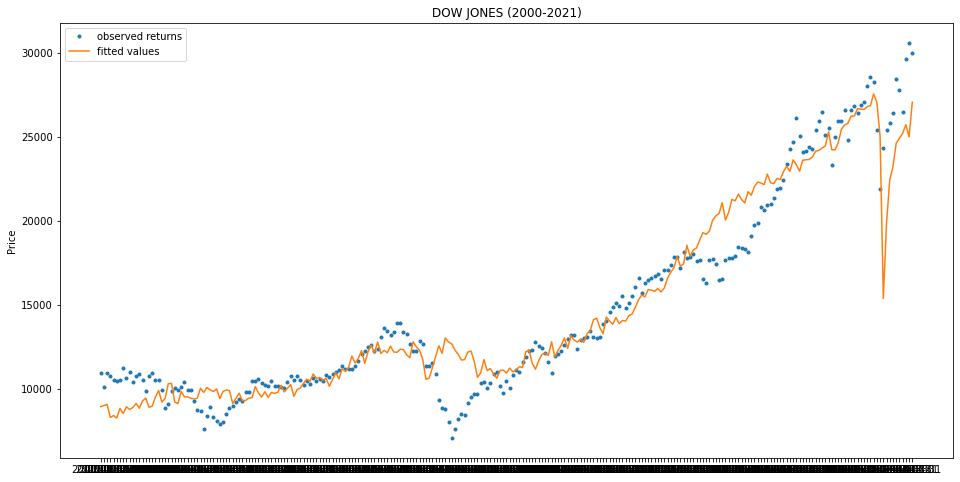

In [34]:
plt.figure(figsize=(16,8))
plt.title('DOW JONES (2000-2021)')
plt.ylabel('Price')
plt.plot(DataReg['Date'],DataReg['price'],'.',label='observed returns')
plt.plot(DataReg['Date'],multi_lin_best_fit_plane(DataReg[['RGDP','UE','CPI','PPI','PCE']], DataReg['price']), label='fitted values')
plt.legend();

In [29]:
model2=sma.ols('price ~ RGDP + UE + CPI + PPI + PCE',DataReg).fit()
print(model2.params)

Intercept    44487.197831
RGDP            -5.013623
UE            -704.261696
CPI            -19.282899
PPI            -80.215688
PCE              6.929077
dtype: float64


# Correlation Heat Map

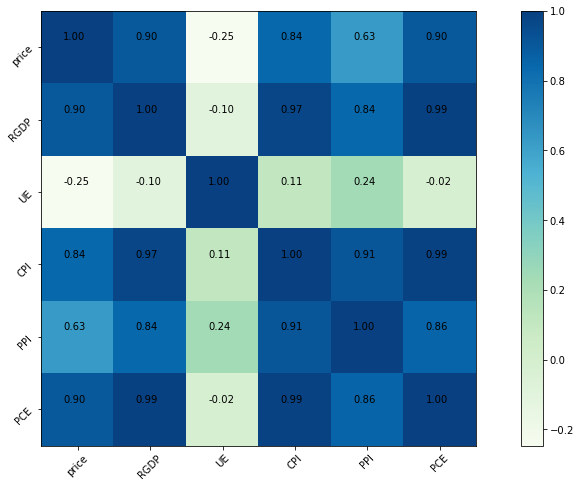

In [31]:
plt.figure(figsize=(16,8))
plt.imshow(DataReg1.corr(),cmap=plt.cm.GnBu,interpolation='nearest',data=True)
plt.colorbar()
tick_marks=[i for i in range(len(DataReg1.columns))]
plt.xticks(tick_marks,DataReg1.columns, rotation=45)
plt.yticks(tick_marks,DataReg1.columns, rotation=45)

for i in range(len(DataReg1.columns)):
    for j in range(len(DataReg1.columns)):
        text = '%.2f'%(DataReg1.corr().iloc[i,j])
        plt.text(i-0.2,j-0.1,text)

# Hypothesis Testing and Model Summary

Since the F-Stat is significantly large, we reject the null hypothesis that the beta coefficients are equal.

In [35]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     510.5
Date:                Wed, 21 Apr 2021   Prob (F-statistic):          5.52e-128
Time:                        14:48:56   Log-Likelihood:                -2247.0
No. Observations:                 253   AIC:                             4506.
Df Residuals:                     247   BIC:                             4527.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.449e+04   1.15e+04      3.869      0.0

# Residual Plots and Feature Selection

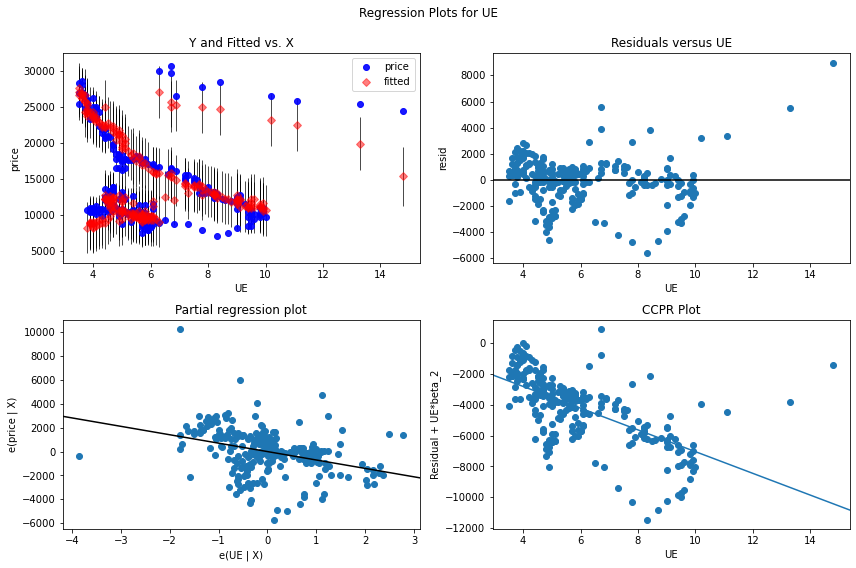

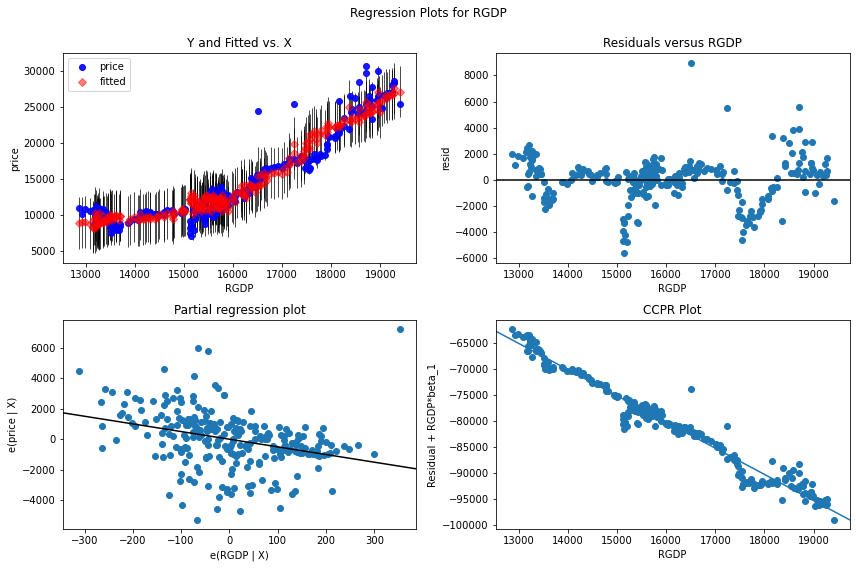

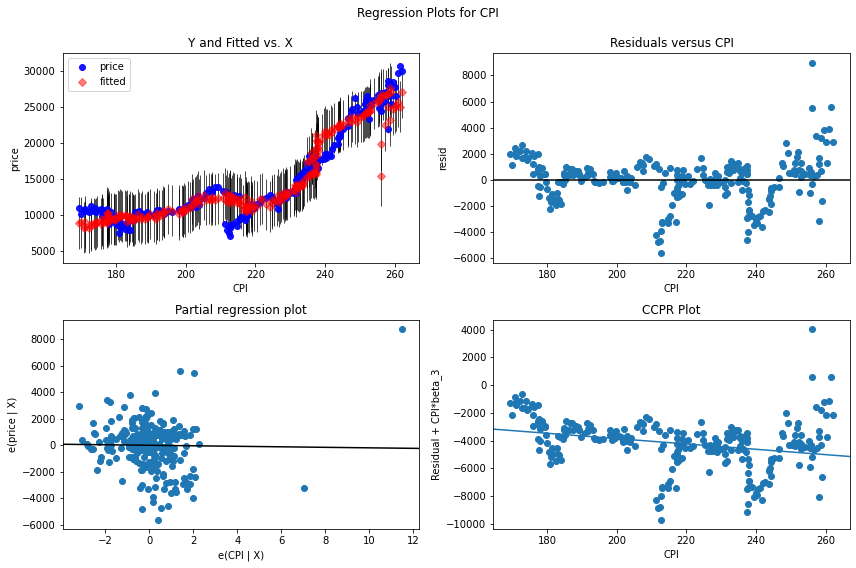

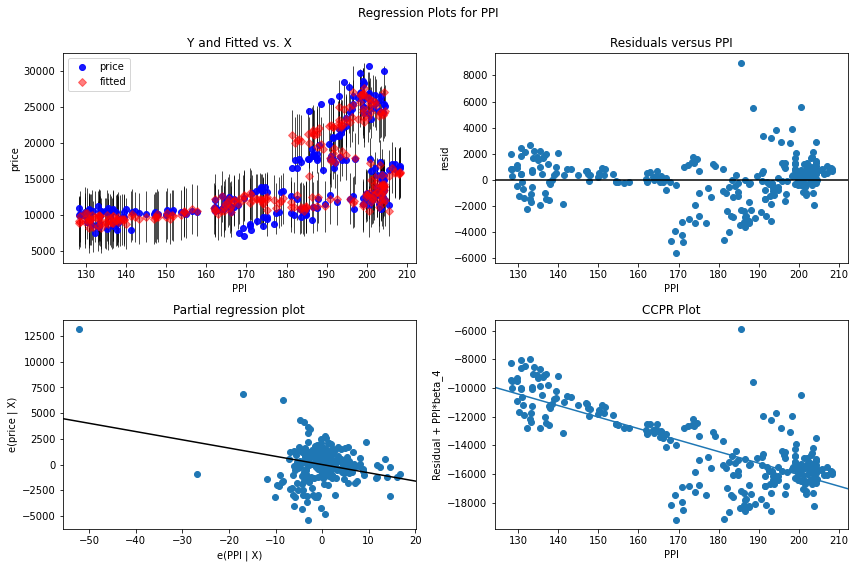

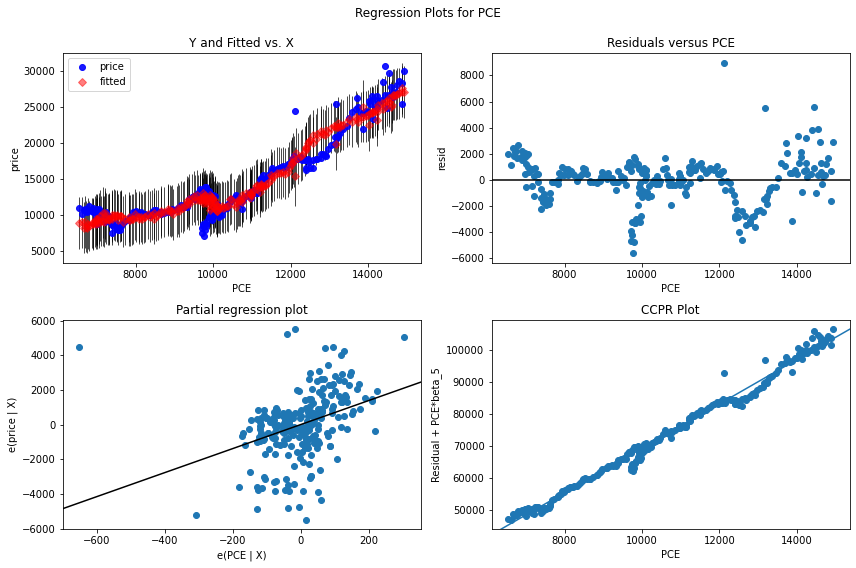

In [44]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model2, 'UE', fig=fig)

fig2 = plt.figure(figsize=(12,8))
fig2 = sm.graphics.plot_regress_exog(model2, 'RGDP', fig=fig2)

fig3 = plt.figure(figsize=(12,8))
fig3 = sm.graphics.plot_regress_exog(model2, 'CPI', fig=fig3)

fig4 = plt.figure(figsize=(12,8))
fig4 = sm.graphics.plot_regress_exog(model2, 'PPI', fig=fig4)

fig5 = plt.figure(figsize=(12,8))
fig5 = sm.graphics.plot_regress_exog(model2, 'PCE', fig=fig5)



